In [ ]:
#! -*- coding: utf-8 -*-

In [ ]:
%matplotlib inline

# GWpyによる信号処理パート2  - 時間領域

先に読み込んだ「生の」時系列データを思い出してください。

Fetched 1 URLs from https://losc.ligo.org for [1126259457 .. 1126259467)
Reading data... [Done]


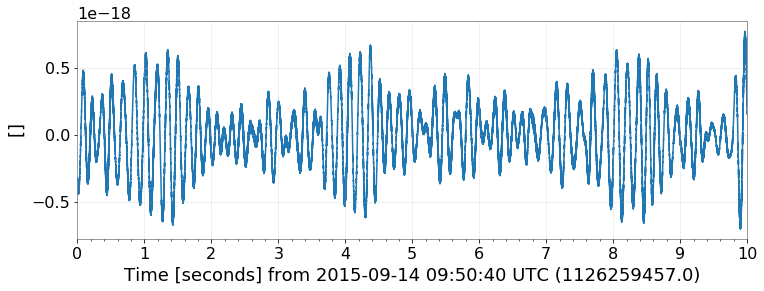

In [3]:
from gwosc.datasets import event_gps
from gwpy.timeseries import TimeSeries

gps = event_gps('GW150914')
segment = (int(gps) - 5, int(gps) + 5)
hdata = TimeSeries.fetch_open_data('H1', *segment, verbose=True, cache=True)
plot = hdata.plot()
plot.show()

ここでは、フィルタリングされていないデータがどのように見えるかを確認します。大きな振幅、低周波のノイズが全体の振幅を支配します。

また、フーリエ変換を使用して、その時系列の周波数領域のパワースペクトルを調べることができることも学びました。

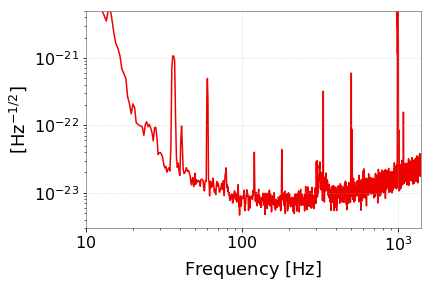

In [2]:
hasd = hdata.asd(fftlength=2)
plot2 = hasd.plot(color='gwpy:ligo-hanford')
ax = plot2.gca()
ax.set_xlim(10, 1400)
ax.set_ylim(3e-24, 5e-21)
plot2.show()

データはいくつかの種類のノイズに支配されていることがわかります。

- 低頻度
- 非常に高い周波数
- スペクトル線

私たちがtimeseriesを（想定される？）イベント時間の前後にズームしても、明らかなものは見えません：

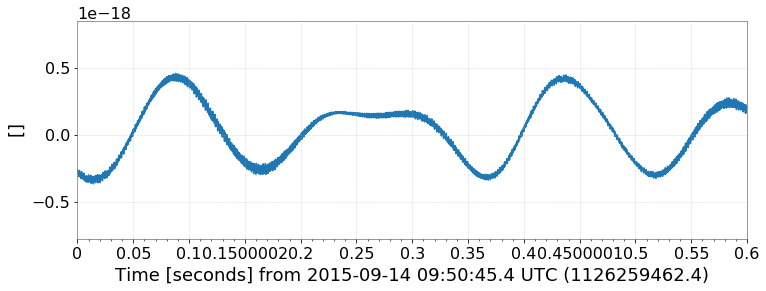

In [4]:
ax = plot.gca()
ax.set_epoch(gps)  # set T=0 on the X-axis
ax.set_xlim(gps, gps+.6)
plot

理想的には、私たちは時系列のノイズを除去し、時間領域のフィルタリングをしたいと考えています。

これらのデータをフィルタリングして、興味のある帯域外の周波数でノイズを除去することができます。
GW150914は、LIGO検出器で~50Hzと~250Hzの間で分解可能な「高質量」バイナリブラックホール合併に由来しています。
他の事象については、信号形態に応じてバンドパスの周波数を微調整する必要があるかもしれない。

In [5]:
hbp = hdata.bandpass(50, 250, filtfilt=True)

<div class="alert alert-info">
`filtfilt = True`を使用してフィルタを2回、1回は前方に、1回は後方に実行します。これにより、フィルタ応答によって導入されるあらゆる位相シフトが最終的に相殺されることが保証されます。
</div>

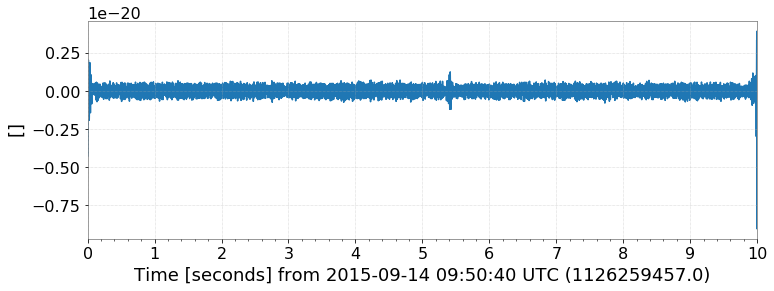

In [6]:
plot = hbp.plot()

最初の振幅が他のデータよりもはるかに高いため、このy軸のスケーリングはちょっと奇妙に見えます。これは、フィルタが良好な状態に落ち着くのに何分の1秒以上かかるからです。

ここで行うべき最善のことは、最初の1秒と最後の1秒のデータを捨てることです（私たちは2回フィルタリングをしたことを思い出してください）。[`.crop()`](https://gwpy.github.io/docs/stable/api/gwpy.timeseries.TimeSeries.html#gwpy.timeseries.TimeSeries.crop) メソッドに新しいGPS スタートタイム、エンドタイムを使ってできます。

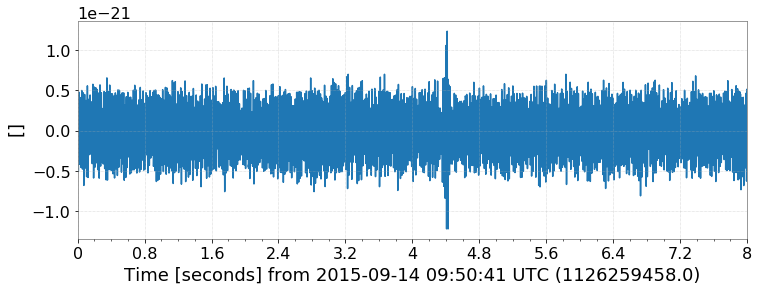

In [7]:
hbp = hbp.crop(int(gps) - 4, int(gps) + 4)
plot = hbp.plot()

これで、T = 5.5秒で、データに強いピークが明確に現れます。興味のある時間にプロットを拡大することができます：

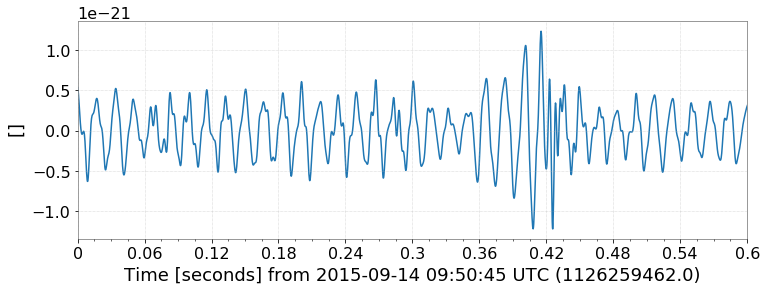

In [8]:
ax = plot.gca()
ax.set_epoch(int(gps))
ax.set_xlim(gps-.4, gps+.2)
plot

バイナリマージャーのように見えますか？多分。

（可能な）信号はまだノイズに埋もれているように見えます。もっと多くのフィルタリング！

我々のASDプロットから、潜在的な重力波信号よりもはるかに大きいデータの大きなスペクトルピークが得られます。これらの周波数で電力を消費する特殊なフィルタを設計することができます。 60Hz米国の主電源の基本波と次の2つの高調波を取り除きましょう。

<div class="alert alert-info">
LIGOデータには、さらに多くのスペクトル線が存在します（詳細については、[ここ](https://losc.ligo.org/o1speclines/)を参照してください）。 60Hz電源の本線と高調波は、50〜250Hz帯で最も大きなものです。</div>

[`gwpy.signal.filter_design`](https://gwpy.github.io/docs/stable/signal/#filter-design) モジュールを使って、一連の[notches](https://gwpy.github.io/docs/stable/signal/#gwpy.signal.filter_design.notch)フィルタを作ります。:

In [10]:
from gwpy.signal import filter_design
notches = [filter_design.notch(f, hdata.sample_rate) for f in (60, 120, 180)]
powernotch = filter_design.concatenate_zpks(*notches)

[`filter_design.contatenate_zpks`](https://gwpy.github.io/docs/stable/signal/index.html#gwpy.signal.filter_design.concatenate_zpks) を使って3つのノッチフィルタを一つのフィルタにして、[`TimeSeries.filter`](https://gwpy.github.io/docs/stable/api/gwpy.timeseries.TimeSeries.html#gwpy.timeseries.TimeSeries.filter)を使用して適用します。:

TimeSeries([  3.26427793e-22,   3.13214730e-22,   2.96629679e-22,
            ...,   5.13211218e-22,   4.98123468e-22,
              4.72246538e-22]
           unit: dimensionless,
           t0: 1126259458.0 s,
           dt: 0.000244140625 s,
           name: Strain,
           channel: None)


(1126259462.0, 1126259462.6000001431)

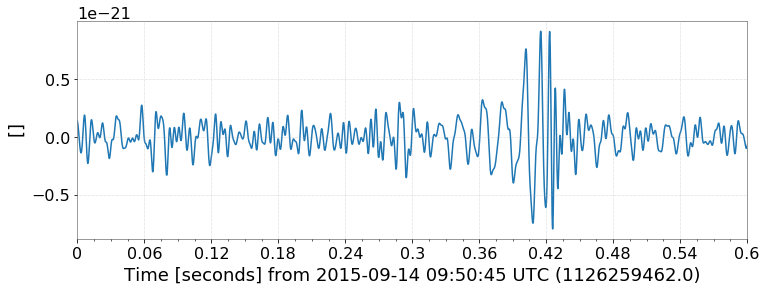

In [11]:
print (hbp)
# hclean = hbp.filter(powernotch, filtfilt=True)
# nk: I had to specify "even" to make it work (20180909)
hclean = hbp.filter(powernotch, filtfilt=True, padtype = "even")
plot = hclean.plot()
ax = plot.gca()
ax.set_epoch(int(gps))
ax.set_xlim(gps-.4, gps+.2)

ようやく私たちはきれいな信号を見ることができます！最後に、少し良く見えるプロットを作ることができます：

Text(0.5,1,'LIGO-Hanford strain data around GW150914')

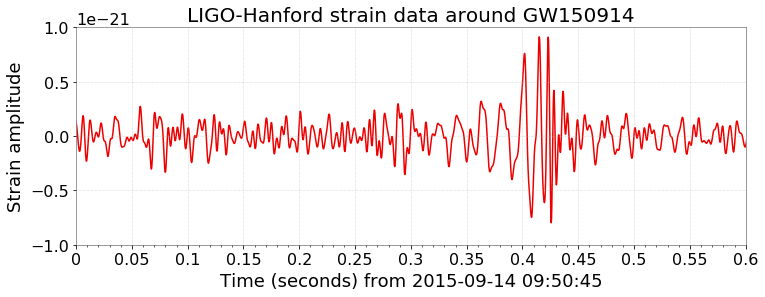

In [12]:
plot = hclean.plot(figsize=(12, 4), color='gwpy:ligo-hanford')
ax = plot.gca()
ax.set_xscale('seconds', epoch=int(gps))
ax.set_xlim(int(gps), int(gps)+.6)
ax.set_xlabel('Time (seconds) from 2015-09-14 09:50:45')
ax.set_ylim(-1e-21, 1e-21)
ax.set_ylabel('Strain amplitude')
ax.set_title('LIGO-Hanford strain data around GW150914')

ユーレカ！それは素晴らしい、きれいな重力波の痕跡のように見えます、まさに理論が予言したバイナリブラックホールのマージャーから来るものです。


<div class="alert alert-warning">
この種の時間領域フィルタリングは、検出を主張する実際の重力波探索では使用されていません。これらの解析では、より堅牢な方法（マッチドフィルタ）が使用されています。

## チャレンジ：

- GW170817のH1から `C00`データをクリーンアップし、上のようなプロットを作成します

Fetched 1 URLs from https://losc.ligo.org for [1187008382 .. 1187009382)
Reading data... [Done]


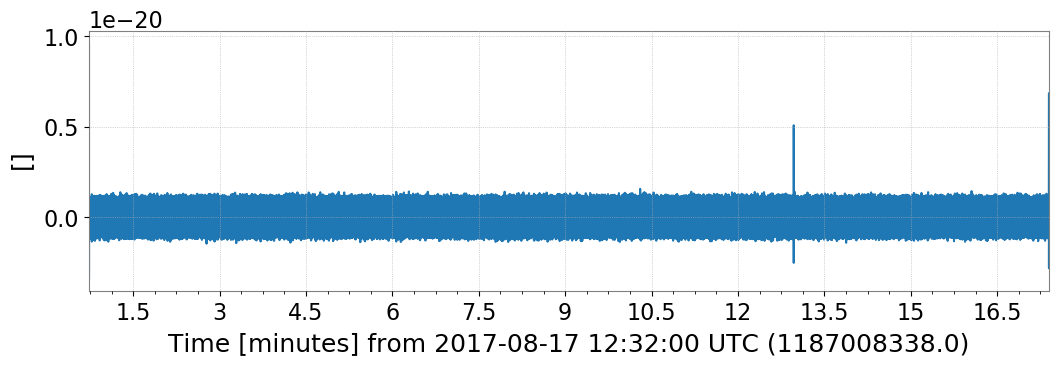

In [1]:
from gwosc.datasets import event_gps
from gwpy.timeseries import TimeSeries

gps = event_gps('GW170817')
igps = int(gps)
segment = (int(gps) - 500, int(gps) + 500)
hdata = TimeSeries.fetch_open_data('H1', *segment, verbose=True, cache=True, tag='C00')

hbp = hdata.bandpass(50, 250, filtfilt=True)
plot = hbp.plot()

Fetched 1 URLs from https://losc.ligo.org for [1187008382 .. 1187009382)
Reading data... [Done]


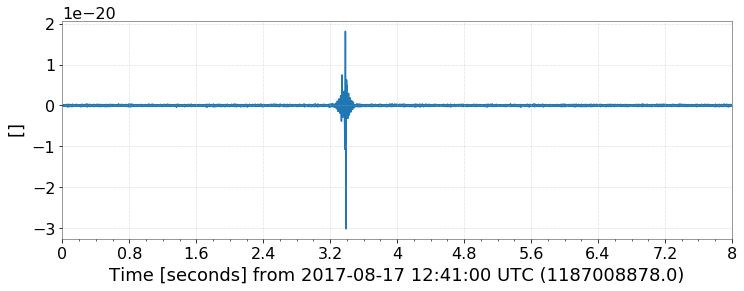

In [9]:
from gwosc.datasets import event_gps
from gwpy.timeseries import TimeSeries

gps = event_gps('GW170817')
igps = int(gps)
segment = (int(gps) - 500, int(gps) + 500)
hdata = TimeSeries.fetch_open_data('L1', *segment, verbose=True, cache=True, tag='C00')

hbp = hdata.bandpass(50, 250, filtfilt=True)
hbp = hbp.crop(int(gps) - 4, int(gps) + 4)
plot = hbp.plot()
